# Feature Engineering
데이터 EDA에 필요한 feature들을 생성하는 과정입니다.

최종 생성된 feature는 다음과 같습니다.
`avg_words_per_sent` == 문장 당 평균 어절 수 (높을수록 통사적 구조가 복잡)

`num_paragraphs` == 문단 수

`lq_ttr` == 어휘 다양성 (동일단어의 반복이 적고 새 단어가 많을수록 높음)

`lq_term_density` == 전문 용어의 밀도 (높을수록 배경지식 요구도 높음)

`lq_modifier_ratio`== 관형사/부사 비중 (높을수록 수식 관계가 정교하고 복잡)

`lq_score` == 최종 언어 복잡도 점수 (`avg_words_per_sent` + `lq_ttr` + `lq_term_density` + `lq_modifier_ratio`)

`q_p_similarity` == 질문과 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

`choice_p_similarity` == 보기와 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

## 필요 라이브러리 임포트 및 난수 고정

In [1]:
import torch
from ast import literal_eval
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import koreanize_matplotlib
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import hashlib
from kiwipiepy import Kiwi
import ast

pd.set_option('display.max_columns', None)

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## 데이터 로드 및 기본 정보

In [3]:
import pandas as pd
from ast import literal_eval

# 데이터 로드
dataset = pd.read_csv('../data/train_source_labeled.csv') 
df = pd.DataFrame(dataset)

# print(f"데이터 로드 완료: 총 {len(df)}개의 문항")
# display(df.head(3))
records = []
for _, row in dataset.iterrows():
    # 1. problems 컬럼 파싱 (문자열일 경우 딕셔너리로 변환)
    problems = row['problems']
    if isinstance(problems, str):
        try:
            problems = literal_eval(problems)
        except:
            problems = {} # 파싱 실패 시 빈 딕셔너리
    
    # 2. 데이터 추출 (최상위 컬럼 우선, 없으면 problems 내부 확인)
    # 질문 내용
    q_text = row.get('question') if pd.notna(row.get('question')) else problems.get('question', "")
    
    # 질문 부가 정보 (question_plus)
    q_plus = row.get('question_plus') if pd.notna(row.get('question_plus')) else problems.get('question_plus', None)
    
    # 선택지 및 정답 (보통 problems 내부에 리스트/숫자로 존재)
    choices = problems.get('choices', [])
    answer = problems.get('answer', None)
    
    # 3. 레코드 생성
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': q_text,
        'choices': choices,
        'answer': answer,
        'question_plus': q_plus,
        'subject': row.get('subject', 'unknown'),
        'from': row.get('from', 'unknown')       
    }
    records.append(record)

# 데이터프레임 변환
df = pd.DataFrame(records)

# 결과 확인
print(f"평탄화 완료: 총 {len(df)}개의 문항")
display(df.head())

평탄화 완료: 총 2031개의 문항


,id,paragraph,question,choices,answer,question_plus,subject,from
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU


In [4]:
df.columns

Index(['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus',
       'subject', 'from'],
      dtype='object')

In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
subject             0
from                0
dtype: int64


In [6]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
 6   subject        2031 non-null   object
 7   from           2031 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.1+ KB


## Subject Mapping

In [7]:
# Subject Mapping
subject_mapping = {
    'korean_history' : '한국사',
    'high_school_european_history' : '세계사',
       'high_school_geography' : '지리',
       'high_school_government_and_politics': '정치와 법',
       'high_school_macroeconomics' : '거시 경제', 
       'high_school_microeconomics' : '미시 경제', 
       'high_school_psychology' : '심리학', 
       'high_school_us_history' : '세계사',
       'high_school_world_history' : '세계사', 
    #    '경제' : '경제',
        # '생활' : '생활과 윤리',
        # '책마을' : '?', 
    #     '사회' : '??',
    #     '부동산' : '경제',
    #     '국제' : '국제' ,
    #    '교육산업' : 

}
df['subject'] = df['subject'].replace(subject_mapping)

print("과목명 치환 결과")
print(df['subject'].unique())

과목명 치환 결과
['한국사' '세계사' '지리' '정치와 법' '거시 경제' '미시 경제' '심리학' '경제' '생활' '책마을' '사회' '부동산'
 '국제' '교육산업']


## 오답지의 매력도 (S-BERT)
왕 == 군주와 같은 의미 기반

In [8]:
# 1. 모델 로드 (한국어 성능이 우수한 S-BERT 모델)
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_hybrid_attractiveness_sbert(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 조합형 문제 확인 및 텍스트 추출 ---
    # 지문에 'ㄱ.' 형태의 패턴이 있는지 검사
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))

    if is_combination:
        # 지문 하단 기호(ㄱ, ㄴ, ㄷ...) 뒤의 실제 텍스트 내용 추출
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match:
                tag_content[tags[i]] = match.group(1).strip()
        
        # 선택지 기호를 실제 문장으로 치환하여 합성
        processed_choices = []
        for c in choices:
            actual_text = ""
            for tag, content in tag_content.items():
                if tag in str(c):
                    actual_text += content + " "
            processed_choices.append(actual_text.strip() if actual_text else str(c))
    else:
        # 일반 문항은 선택지 텍스트 그대로 사용
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] S-BERT 임베딩 생성 ---
    # 선택지 전체를 벡터화
    choice_embeddings = model.encode(processed_choices)
    
    # 지문 텍스트 벡터화 (조합형인 경우 기호 부분 제외하고 본문만 추출)
    clean_p_text = re.sub(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)].*', '', p_text, flags=re.S) if is_combination else p_text
    p_embedding = model.encode([clean_p_text])
    
    # 정답 벡터 추출
    answer_embedding = choice_embeddings[answer_idx].reshape(1, -1)
    
    distractor_scores = []
    
    # --- [Step 3] 오답별 매력도 계산 ---
    for i, c_emb in enumerate(choice_embeddings):
        if i == answer_idx: 
            continue  # 정답은 계산에서 제외
        
        c_emb = c_emb.reshape(1, -1)
        
        # A) 정답과의 유사도 (재진술/말바꾸기 함정)
        sim_with_answer = cosine_similarity(c_emb, answer_embedding)[0][0]
        
        # B) 지문 본문과의 유사도 (단어 낚시 함정)
        sim_with_para = cosine_similarity(c_emb, p_embedding)[0][0]
        
        # 두 유사도 중 더 높은 것을 해당 오답의 '매력도'로 간주
        distractor_scores.append(max(sim_with_answer, sim_with_para))
    
    # 해당 문항에서 가장 매력적인 오답의 점수를 반환
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 2. 데이터프레임에 적용
print("S-BERT 하이브리드 모드로 오답 매력도 계산 중...")
df['distractor_attractiveness'] = df.apply(calculate_hybrid_attractiveness_sbert, axis=1)
print("계산 완료 'distractor_attractiveness' 컬럼이 추가되었습니다.")

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


S-BERT 하이브리드 모드로 오답 매력도 계산 중...
계산 완료 'distractor_attractiveness' 컬럼이 추가되었습니다.


## 오답지의 매력도(SimHash)
단어 기반

In [9]:
def get_simhash(text):
    """텍스트의 SimHash 값을 64비트 정수로 생성"""
    if not text or len(str(text).strip()) == 0:
        return 0
    
    # 1. 특징 추출 (단어 단위 분절)
    features = str(text).split()
    v = [0] * 64  # 64비트 해시 벡터
    
    for f in features:
        # 각 단어의 고유 해시값 생성 (MD5 활용)
        t = int(hashlib.md5(f.encode('utf-8')).hexdigest(), 16)
        for i in range(64):
            bitmask = 1 << i
            if t & bitmask:
                v[i] += 1  # 비트가 1이면 가중치 증가
            else:
                v[i] -= 1  # 비트가 0이면 가중치 감소
                
    # 2. 결과 비트 생성
    fingerprint = 0
    for i in range(64):
        if v[i] >= 0:
            fingerprint |= (1 << i)
            
    return fingerprint

def get_hamming_similarity(hash1, hash2):
    """해밍 거리를 이용한 유사도 산출 (0~1 사이)"""
    # XOR 연산 후 1의 개수를 세어 해밍 거리를 구함
    x = hash1 ^ hash2
    hamming_dist = bin(x).count('1')
    # 64비트 기준 유사도로 변환 (거리가 0이면 유사도 1)
    return 1 - (hamming_dist / 64)

def calculate_simhash_attractiveness(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 하이브리드 텍스트 추출 (조합형 여부 판단) ---
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))
    processed_choices = []

    if is_combination:
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match: tag_content[tags[i]] = match.group(1).strip()
        
        for c in choices:
            actual_text = " ".join([tag_content[tag] for tag in tag_content if tag in str(c)])
            processed_choices.append(actual_text if actual_text else str(c))
    else:
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] SimHash 기반 유사도 계산 ---
    choice_hashes = [get_simhash(c) for c in processed_choices]
    p_hash = get_simhash(p_text)
    ans_hash = choice_hashes[answer_idx]
    
    distractor_scores = []
    for i, dist_hash in enumerate(choice_hashes):
        if i == answer_idx: continue
        
        # 정답 해시와 비교 + 지문 해시와 비교
        sim_with_ans = get_hamming_similarity(dist_hash, ans_hash)
        sim_with_p = get_hamming_similarity(dist_hash, p_hash)
        
        distractor_scores.append(max(sim_with_ans, sim_with_p))
        
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 데이터 적용
print("SimHash로 오답 매력도 계산 중...")
df['distractor_attractiveness_simhash'] = df.apply(calculate_simhash_attractiveness, axis=1)
print("계산 완료 'distractor_attractiveness_simhash' 컬럼이 추가되었습니다.")

SimHash로 오답 매력도 계산 중...
계산 완료 'distractor_attractiveness_simhash' 컬럼이 추가되었습니다.


## 오답지의 매력도(통합)

의미기반과 단어기반을 비교했을때, 가장 큰 유사도를 가지는 점수로 선정

In [10]:
def calculate_final_distractor_attractiveness(row):
    p_text = str(row['paragraph']) if row['paragraph'] else ""
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer = row.get('answer')
    
    if not choices or not answer or not p_text.strip():
        return 0.0
    
    try:
        answer_idx = int(answer) - 1
        ans_text = str(choices[answer_idx])
        distractors = [str(c) for i, c in enumerate(choices) if i != answer_idx]
        
        # --- 1. 임베딩(S-BERT) 기반 매력도 ---
        # 선지들과 (정답 + 지문) 간의 의미적 유사도 측정
        p_embedding = model.encode([p_text])
        ans_embedding = model.encode([ans_text])
        dist_embeddings = model.encode(distractors)
        
        # 오답이 정답과 비슷하거나, 지문과 비슷할수록 매력적임
        sim_with_ans_emb = cosine_similarity(dist_embeddings, ans_embedding)
        sim_with_p_emb = cosine_similarity(dist_embeddings, p_embedding)
        
        # 각 오답별로 (정답유사도, 지문유사도) 중 큰 값을 취함
        emb_scores = np.maximum(sim_with_ans_emb, sim_with_p_emb)
        max_emb_score = float(np.max(emb_scores))

        # --- 2. SimHash 기반 매력도 (자구적 유사도) ---
        def get_simhash_val(text):
            features = str(text).split()
            v = [0] * 64
            for f in features:
                t = int(hashlib.md5(f.encode('utf-8')).hexdigest(), 16)
                for i in range(64):
                    if t & (1 << i): v[i] += 1
                    else: v[i] -= 1
            fingerprint = 0
            for i in range(64):
                if v[i] >= 0: fingerprint |= (1 << i)
            return fingerprint

        def hamming_sim(h1, h2):
            return 1 - (bin(h1 ^ h2).count('1') / 64)

        p_hash = get_simhash_val(p_text)
        ans_hash = get_simhash_val(ans_text)
        dist_hashes = [get_simhash_val(d) for d in distractors]
        
        sh_scores = [max(hamming_sim(dh, ans_hash), hamming_sim(dh, p_hash)) for dh in dist_hashes]
        max_sh_score = float(np.max(sh_scores))

        # --- 3. 최종 결합 (Ensemble) ---
        # 두 점수 중 높은 것을 취하거나 가중 평균 사용
        # 여기서는 두 측면 중 하나라도 높으면 매력적인 오답으로 판단 (Max 방식)
        final_score = max(max_emb_score, max_sh_score)
        
        return final_score

    except Exception as e:
        return 0.0

# 피처 적용
print("임베딩 + SimHash 통합 오답 매력도 계산 중...")
df['final_distractor_attractiveness'] = df.apply(calculate_final_distractor_attractiveness, axis=1)
print("계산 완료 'final_distractor_attractiveness' 컬럼이 추가되었습니다.")

임베딩 + SimHash 통합 오답 매력도 계산 중...
계산 완료 'final_distractor_attractiveness' 컬럼이 추가되었습니다.


In [11]:
display(df.head(3))

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,한국사,KMMLU,0.805455,0.703125,0.858223
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,한국사,KMMLU,0.478597,0.656250,0.656250
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,한국사,KMMLU,0.409381,0.656250,0.656250


## 4지선다 or 5지선다

In [12]:
# 1. 선지 리스트의 길이를 계산하여 'num_choices' 열 생성
# choices 컬럼이 리스트 형태인 경우 len()을 사용하고, 
# 만약 결측치(NaN)가 있다면 0으로 처리합니다.
df['num_choices'] = df['choices'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 2. 결과 확인: 4지선다와 5지선다의 분포 확인
print("### 선지 개수별 문항 분포 ###")
print(df['num_choices'].value_counts().sort_index())

# 3. 데이터 샘플 확인
display(df[['id', 'choices', 'num_choices']].head())

### 선지 개수별 문항 분포 ###
num_choices
4     792
5    1239
Name: count, dtype: int64


,id,choices,num_choices
0,generation-for-nlp-425,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",4
1,generation-for-nlp-426,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",4
2,generation-for-nlp-427,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4
3,generation-for-nlp-428,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",4
4,generation-for-nlp-429,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",4


In [13]:
def fix_and_create_num_choices(df):
    # 1. 문자열로 되어 있는 리스트를 실제 리스트 객체로 변환
    # 이미 리스트라면 그대로 두고, 문자열일 경우만 변환합니다.
    def parse_to_list(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except (ValueError, SyntaxError):
                return [] # 변환 실패 시 빈 리스트
        return x if isinstance(x, list) else []

    # 'choices' 컬럼 정제
    df['choices'] = df['choices'].apply(parse_to_list)

    # 2. 선지 리스트의 길이를 계산하여 'num_choices' 열 생성
    df['num_choices'] = df['choices'].apply(len)

    # 3. 결과 확인
    print("### [검증] 선지 개수(num_choices) 분포 ###")
    print(df['num_choices'].value_counts().sort_index())
    
    return df

# 실행
df = fix_and_create_num_choices(df)

# 샘플 확인
display(df[['choices', 'num_choices']].head())

### [검증] 선지 개수(num_choices) 분포 ###
num_choices
4     792
5    1239
Name: count, dtype: int64


,choices,num_choices
0,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",4
1,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",4
2,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4
3,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",4
4,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",4


## LQ 지수를 위한 피처 생성
`avg_words_per_sent` == 문장 당 평균 어절 수 (높을수록 통사적 구조가 복잡)

`num_paragraphs` == 문단 수

`lq_ttr` == 어휘 다양성 (동일단어의 반복이 적고 새 단어가 많을수록 높음)

`lq_term_density` == 전문 용어의 밀도 (높을수록 배경지식 요구도 높음)

`lq_modifier_ratio`== 관형사/부사 비중 (높을수록 수식 관계가 정교하고 복잡)

`lq_score` == 최종 언어 복잡도 점수 (`avg_words_per_sent` + `lq_ttr` + `lq_term_density` + `lq_modifier_ratio`)

In [14]:
# Kiwi 초기화
kiwi = Kiwi()

def calculate_lq_features(row):
    p_text = str(row['paragraph']).strip() if pd.notna(row['paragraph']) else ""
    if not p_text:
        return pd.Series([0.0] * 6)

    try:
        # --- [A] 기초 언어적 분석 ---
        sentences = kiwi.split_into_sents(p_text)
        num_sentences = len(sentences)
        words = p_text.split()
        avg_words_per_sent = len(words) / num_sentences if num_sentences > 0 else 0
        num_paragraphs = len([p for p in p_text.split('\n') if p.strip()])
        
        # --- [B] 형태소 분석 ---
        tokens = kiwi.tokenize(p_text)
        nouns = [t.form for t in tokens if t.tag.startswith('N')]
        unique_nouns = [n for n in nouns if len(n) >= 3] 
        modifiers = [t.form for t in tokens if t.tag in ['MM', 'MAG']]
        
        # --- [C] LQ 지수 관련 피처 ---
        ttr = len(set(nouns)) / len(nouns) if len(nouns) > 0 else 0
        term_density = len(unique_nouns) / len(words) if len(words) > 0 else 0
        modifier_ratio = len(modifiers) / len(words) if len(words) > 0 else 0
        lq_score = (avg_words_per_sent * 0.4) + (term_density * 30) + (modifier_ratio * 10) + (ttr * 5)

        return pd.Series([avg_words_per_sent, num_paragraphs, ttr, term_density, modifier_ratio, lq_score])
    except Exception as e:
        return pd.Series([0.0] * 6)

# LQ 피처 적용
lq_cols = ['avg_words_per_sent', 'num_paragraphs', 'lq_ttr', 'lq_term_density', 'lq_modifier_ratio', 'lq_score']
df[lq_cols] = df.apply(calculate_lq_features, axis=1)

## 추론 난이도 관련 피처 생성
`q_p_similarity` == 질문과 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

`choice_p_similarity` == 보기와 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

In [15]:
# 모델 로드 (이미 로드되어 있다면 생략 가능)
# model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_embedding_similarities(row):
    p_text = str(row['paragraph']).strip() if pd.notna(row['paragraph']) else ""
    q_text = str(row['question']).strip() if pd.notna(row['question']) else ""
    choices = row['choices'] if isinstance(row['choices'], list) else []
    
    if not p_text:
        return pd.Series([0.0, 0.0])

    try:
        # 지문 임베딩 (공통 사용)
        p_embedding = model.encode([p_text], show_progress_bar=False)
        
        # 1. 질문-지문 유사도 계산
        q_embedding = model.encode([q_text], show_progress_bar=False)
        q_p_sim = float(cosine_similarity(p_embedding, q_embedding)[0][0])
        
        # 2. 선지-지문 유사도(추론 깊이) 계산
        if choices:
            c_embeddings = model.encode([str(c) for c in choices], show_progress_bar=False)
            choice_p_sims = cosine_similarity(c_embeddings, p_embedding)
            choice_p_sim = float(np.mean(choice_p_sims))
        else:
            choice_p_sim = 0.0
            
        return pd.Series([q_p_sim, choice_p_sim])
    except Exception as e:
        return pd.Series([0.0, 0.0])

# 데이터프레임 적용
print("임베딩 기반 유사도(질문, 선지) 계산 중...")
df[['q_p_similarity', 'choice_p_similarity']] = df.apply(calculate_embedding_similarities, axis=1)

임베딩 기반 유사도(질문, 선지) 계산 중...


## 질문 유형 관련 피처 생성
`is_negative` == 부정형 질문 여부

### 키워드 기반 생성

In [ ]:
# def check_is_negative(row):
#     q_text = str(row['question']).strip() if pd.notna(row['question']) else ""
    
#     # 부정형 질문 키워드 리스트
#     negative_keywords = [
#     '않은', '못한', '없는', '틀린', '아닌', '적절하지', 
#     '부합하지', '어긋나는', '거리가 먼', '타당하지', 
#     '옳지 않은', '일치하지'
#     ]

#     # 키워드가 하나라도 포함되면 1, 아니면 0
#     return 1 if any(word in q_text for word in negative_keywords) else 0

# # 데이터프레임 적용
# print("부정 질문 여부 판별 중...")
# df['is_negative'] = df.apply(check_is_negative, axis=1)
# print("부정 질문 여부 피처 추가 완료")

부정 질문 여부 판별 중...
부정 질문 여부 피처 추가 완료


In [17]:
# def categorize_question_ensemble(row):
#     q_text = str(row['question']).strip()
#     p_text = str(row['paragraph']).strip()
    
#     # 분석용 토큰화
#     tokens = kiwi.tokenize(q_text)
#     token_forms = [t.form for t in tokens]
#     full_text = "".join(token_forms)
    
#     # 유형별 가중치 초기화
#     scores = {'Fact': 0, 'Inference': 0, 'Application': 0, 'Evaluation': 0}
    
#     # 1. 출발점 및 구조 분석 (질문 앞부분/지문 연계)
#     if '<보기>' in q_text or '<보기>' in p_text:
#         scores['Application'] += 3  # <보기>는 강력한 적용 유형 지표
#     if '바탕으로' in q_text or '참고하여' in q_text:
#         scores['Application'] += 2
#         scores['Inference'] += 1
#     if re.search(r'ㄱ|ㄴ|ㄷ|①', q_text):
#         scores['Inference'] += 1  # 특정 지시 대상을 묻는 경우

#     # 2. 중간 논리 부사 분석
#     if '가장' in q_text:
#         scores['Inference'] += 2  # '가장' 적절한 것은 최적의 추론을 요구
#     if '모두' in q_text:
#         scores['Fact'] += 1      # 나열된 정보의 전수 조사는 대개 사실 확인

#     # 3. 최종 어미/서술어 분석 (질문 뒷부분 5어절 집중)
#     tail_text = "".join(token_forms[-7:])
    
#     # [비판/평가]
#     if any(w in tail_text for w in ['비판', '반박', '전제', '적절한가', '한계']):
#         scores['Evaluation'] += 4
#     # [적용/분석]
#     elif any(w in tail_text for w in ['이해', '반응', '사례', '적용']):
#         scores['Application'] += 2
#     # [추론]
#     elif any(w in tail_text for w in ['적절', '옳은', '추론', '이유', '까닭', '의미']):
#         scores['Inference'] += 2
#     # [사실/일치]
#     elif any(w in tail_text for w in ['일치', '부합', '언급', '내용으로']):
#         scores['Fact'] += 3

#     # 4. 최종 결정 (동점 시 Application > Evaluation > Inference > Fact 순)
#     # 가중치가 전혀 없으면 기본값 Inference
#     if max(scores.values()) == 0:
#         return 'Inference'
    
#     return max(scores, key=lambda k: (scores[k], ['Fact', 'Inference', 'Evaluation', 'Application'].index(k)))

# # 데이터프레임 적용
# df['q_type_ensemble'] = df.apply(categorize_question_ensemble, axis=1)

In [18]:
# # 한글 폰트 설정
# plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['axes.unicode_minus'] = False

# # 1. 질문 유형별 빈도수 (Bar Chart)
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# ax = sns.countplot(x='q_type_ensemble', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])
# plt.title('질문 유형별 문항 수 분포', fontsize=14, fontweight='bold')
# plt.xlabel('질문 유형')
# plt.ylabel('문항 수')

# # 바 위에 숫자 표기
# for p in ax.patches:
#     ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.4, p.get_height()+0.2), ha='center')

# # 2. 질문 유형별 지문 난이도(LQ) 분포 (Boxplot)
# plt.subplot(1, 2, 2)
# sns.boxplot(x='q_type_ensemble', y='lq_score', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])
# plt.title('질문 유형별 지문 난이도(LQ) 비교', fontsize=14, fontweight='bold')
# plt.xlabel('질문 유형')
# plt.ylabel('LQ Score')

# plt.tight_layout()
# plt.show()

### OPENAI 기반 생성

In [19]:
api_key = 'hello'

In [29]:
import pandas as pd
import openai
import json
from tqdm import tqdm

# 1. API 설정 (사용자님의 실제 키를 입력하세요)
client = openai.OpenAI(api_key=api_key) 

def extract_bloom_features_minimal(row):
    """
    지문(최대 1000자), 질문, 선택지를 분석하여 인지적 영역을 분류합니다.
    """
    # 데이터 추출 및 지문 1000자 제한
    q = str(row.get('question', ''))
    c = str(row.get('choices', ''))

    # 프롬프트: 지문의 맥락을 반영하여 더 정확한 Bloom 유형 판단
    prompt = f"""
    당신은 블룸(Bloom)의 인지적 영역 분류 전문가입니다. 
    제시된 지문 일부와 질문, 선지를 분석하여 문항 특성을 JSON으로 분류하세요.

    [Input]
    - 질문: {q}
    - 선지: {c}

    [Task]
    1. is_negative: 질문이 '옳지 않은 것', '틀린 것' 등을 묻는 부정형인가? (true/false)
    2. cognitive_type: 다음 중 하나 선택: [지식/이해, 적용, 분석, 평가]
       - '지식/이해': 인지나 재생에 의하여 아이디어나 자료, 현상을 기억해내는 능력, 전달된 내용에 포함된 자료나 아이디어를 이용할 수 있는 능력 
       - '적용': 새로운 문제 사태에 방법, 원리, 학설, 추상개념을 적용하여 문제를 해결하는 능력, 일반 법칙을 추출하고, 그것을 정당화시키기 위해서는 귀납적 혹은 연역적 추리 등의 사고 과정이 동원되는 능력
       - '분석': 자료의 구성부분을 분해하고 부분간의 관계와 그것이 조직되어 있는 방식을 발견하는 능력
       - '평가': 어떤 목적으로 아이디어, 작품, 해답, 방법, 소재 등의 가치를 판단하는 능력
    3. reasoning_step: 사고 단계 (1: 직접 추출, 2: 단순 유치, 3: 복합 추론)

    반드시 아래 JSON 형식으로만 응답하세요:
    {{
      "is_negative": boolean,
      "cognitive_type": "string",
      "reasoning_step": integer
    }}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "교육 데이터 분석 전문가입니다. JSON으로만 답변합니다."},
                {"role": "user", "content": prompt}
            ],
            response_format={"type": "json_object"}
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        return {"is_negative": None, "cognitive_type": f"Error: {str(e)[:20]}", "reasoning_step": 0}

# 2. 3개 샘플 테스트 실행 함수
def test_bloom_classification(df, num_samples=3):
    # 상위 3개 샘플 추출 (인덱스 보존)
    target_idx = df.index[:num_samples]
    results = []
    
    print(f"📉 gpt-4o-mini 초경제 모드로 {num_samples}건 테스트 시작...")
    
    for idx in tqdm(target_idx):
        res = extract_bloom_features_minimal(df.loc[idx])
        results.append(res)
    
    # 결과 데이터프레임 생성
    res_df = pd.DataFrame(results, index=target_idx)
    
    # 기존 데이터프레임에 임시 열로 추가하여 결과 보기
    test_view = df.loc[target_idx, ['id', 'paragraph', 'question']].copy()
    test_view['is_neg'] = res_df['is_negative']
    test_view['type'] = res_df['cognitive_type']
    test_view['step'] = res_df['reasoning_step']
    
    return test_view

# --- 실행 및 결과 확인 ---
# 크레딧 충전이 완료되었다면 아래 주석을 풀고 실행하세요.
result_sample = test_bloom_classification(df, num_samples=3)
print("\n### [테스트 결과 리포트] ###")
display(result_sample)

📉 gpt-4o-mini 초경제 모드로 3건 테스트 시작...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


### [테스트 결과 리포트] ###


,id,paragraph,question,is_neg,type,step
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,False,분석,2
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,True,분석,3
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,False,지식/이해,1


In [ ]:
# import pandas as pd
# import openai
# import json
# from tqdm import tqdm
# import time

# # 1. API 설정
# client = openai.OpenAI(api_key=api_key)

# def extract_bloom_features_with_para(row):
#     """
#     지문(최대 1000자), 질문, 선택지를 분석하여 인지적 영역을 분류합니다.
#     """
#     # 데이터 추출 및 지문 1000자 제한
#     q = str(row.get('question', ''))
#     c = str(row.get('choices', ''))

#     # 프롬프트: 지문의 맥락을 반영하여 더 정확한 Bloom 유형 판단
#     prompt = f"""
#     당신은 블룸(Bloom)의 인지적 영역 분류 전문가입니다. 
#     제시된 지문 일부와 질문, 선지를 분석하여 문항 특성을 JSON으로 분류하세요.

#     [Input]
#     - 질문: {q}
#     - 선지: {c}

#     [Task]
#     1. is_negative: 질문이 '옳지 않은 것', '틀린 것' 등을 묻는 부정형인가? 부정이면 1, 아니면 0 (1/0)
#     2. cognitive_type: 다음 중 하나 선택: [지식/이해, 적용, 분석, 평가]
#        - '지식/이해': 인지나 재생에 의하여 아이디어나 자료, 현상을 기억해내는 능력, 전달된 내용에 포함된 자료나 아이디어를 이용할 수 있는 능력 
#        - '적용': 새로운 문제 사태에 방법, 원리, 학설, 추상개념을 적용하여 문제를 해결하는 능력, 일반 법칙을 추출하고, 그것을 정당화시키기 위해서는 귀납적 혹은 연역적 추리 등의 사고 과정이 동원되는 능력
#        - '분석': 자료의 구성부분을 분해하고 부분간의 관계와 그것이 조직되어 있는 방식을 발견하는 능력
#        - '평가': 어떤 목적으로 아이디어, 작품, 해답, 방법, 소재 등의 가치를 판단하는 능력
#     3. reasoning_step: 사고 단계 (1: 직접 추출, 2: 단순 유치, 3: 복합 추론)

#     반드시 아래 JSON 형식으로만 응답하세요:
#     {{
#       "is_negative": boolean,
#       "cognitive_type": "string",
#       "reasoning_step": integer
#     }}
#     """

#     try:
#         response = client.chat.completions.create(
#             model="gpt-4o-mini",
#             messages=[
#                 {"role": "system", "content": "수능 문제 분석 전문가입니다. JSON으로만 답변합니다."},
#                 {"role": "user", "content": prompt}
#             ],
#             response_format={"type": "json_object"}
#         )
#         return json.loads(response.choices[0].message.content)
#     except Exception as e:
#         return {"is_negative": None, "cognitive_type": "Error", "reasoning_step": 0}

# # 2. 전체 데이터 적용 함수
# def apply_bloom_full_process(df):
#     target_idx = df.index
#     results = []
    
#     print(f"피처 추출 시작 (총 {len(target_idx)}건)...")
    
#     for idx in tqdm(target_idx):
#         res = extract_bloom_features_with_para(df.loc[idx])
#         results.append(res)
        
#     # 결과 데이터프레임 생성
#     res_df = pd.DataFrame(results, index=target_idx)
    
#     # 원본 데이터프레임에 열 추가
#     df['is_negative_llm'] = res_df['is_negative']
#     df['cognitive_type'] = res_df['cognitive_type']
#     df['reasoning_step'] = res_df['reasoning_step']
    
#     print("✅ 전체 데이터 처리가 완료되었습니다.")
#     return df

# # --- 실행 ---
# df = apply_bloom_full_process(df)

피처 추출 시작 (총 2031건)...


  0%|          | 0/2031 [00:00<?, ?it/s]

100%|██████████| 2031/2031 [40:26<00:00,  1.19s/it] 

✅ 전체 데이터 처리가 완료되었습니다.


In [32]:
display(df.head(8))

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness,num_choices,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,q_p_similarity,choice_p_similarity,is_negative_llm,cognitive_type,reasoning_step
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,한국사,KMMLU,0.805455,0.703125,0.858223,4,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,0.467032,0.249686,0,분석,2
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,한국사,KMMLU,0.478597,0.656250,0.656250,4,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,0.170359,0.261985,1,분석,3
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,한국사,KMMLU,0.409381,0.656250,0.656250,4,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,0.262167,0.385297,0,지식/이해,1
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,한국사,KMMLU,0.516401,0.750000,0.750000,4,29.000000,1.0,0.790698,0.068966,0.103448,18.656937,0.184196,0.412497,0,분석,1
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,한국사,KMMLU,0.468751,0.656250,0.656250,4,19.000000,1.0,0.931034,0.052632,0.105263,14.886751,0.337196,0.298593,1,분석,2
5,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ....",3,None,한국사,KMMLU,0.714516,0.625000,0.714516,4,14.500000,1.0,0.944444,0.103448,0.103448,14.660153,0.379381,0.457274,0,지식/이해,1
6,generation-for-nlp-432,(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의...,다음 사건을 시기 순으로 바르게 나열한 것은?,"[(가)→(라)→(나)→(다), (나)→(다)→(가)→(라), (다)→(나)→(가)...",4,None,한국사,KMMLU,0.995574,0.593750,0.995575,4,12.000000,1.0,0.923077,0.083333,0.000000,11.915385,0.106894,0.411345,0,분석,2
7,generation-for-nlp-433,"신돈이 (가)을/를 설치하자고 요청하자, …(중략)…이 제 도감이 설치되었다. …(...",(가)에 대한 설명으로 옳은 것은?,"[시 전의 물가를 감독하는 임무를 담당하였다 ., 국가재정의 출납과 회계 업무를 총...",3,None,한국사,KMMLU,0.538298,0.734375,0.734375,4,7.333333,1.0,0.888889,0.045455,0.136364,10.105051,0.274697,0.349441,0,지식/이해,1


## 보기의 편향도 유형 피처 생성
극단적 진술(extreme phrasing)에 의한 오답 설계 정도 파악

In [33]:
# Kiwi 초기화
kiwi = Kiwi()

def check_extreme_phrasing_advanced(row):
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer = row.get('answer')
    
    # 데이터가 없으면 NaN 반환
    if not choices or pd.isna(answer):
        return np.nan

    # 1. 단어형 극단적 진술 키워드 (추천 리스트 반영)
    extreme_words = [
        '모두', '항상', '반드시', '오직', '결코', '전혀', '단 하나', '최고의', '무조건', # 기존
        '오로지', '단지', '특정한', '절대로', '필연적', '당연히', '결국',                # 국어/사탐 고도화
        '언제나', '예외 없이', '어떤 경우에도', '최고', '제일', '유일한',              # 전칭/비교
        '급격히', '완전히', '일관되게'                                            # 변화/단일
    ]
    
    extreme_choice_indices = []
    
    for i, choice in enumerate(choices):
        c_text = str(choice).strip()
        is_extreme = False
        
        # [A] 단어형 키워드 매칭
        if any(kw in c_text for kw in extreme_words):
            is_extreme = True
        
        # [B] 형태소 분석기를 이용한 보조사 '만' 추출
        # 문자열에 '만'이 포함된 경우에만 정밀 분석 수행 (효율성)
        if not is_extreme and '만' in c_text:
            tokens = kiwi.tokenize(c_text)
            for t in tokens:
                # '만'이라는 글자이면서 태그가 'JX'(보조사)인 경우만 인정
                if t.form == '만' and t.tag == 'JX':
                    is_extreme = True
                    break
        
        if is_extreme:
            extreme_choice_indices.append(i + 1) # 1~5번 선지 기준

    # 2. 데이터 판별 로직
    # 극단적 표현 선지가 아예 없는 경우 -> NaN
    if not extreme_choice_indices:
        return np.nan
    
    # 3. 정답 여부 확인 (사용자님 요청: 정답이면 1, 아니면 0)
    try:
        correct_answer = int(float(answer)) # 소수점 형태 대응
        if correct_answer in extreme_choice_indices:
            return 1 # 극단적 표현이 정답인 경우 (함정을 깬 사례)
        else:
            return 0 # 극단적 표현이 정답이 아닌 경우 (일반적 오답 설계)
    except (ValueError, TypeError):
        return np.nan

# 피처 적용
print("Kiwi 형태소 분석 및 극단적 진술 피처 생성 중...")
df['extreme_correct_match'] = df.apply(check_extreme_phrasing_advanced, axis=1)

# 생성 결과 확인
print("\n[ 레이블별 문항 수 확인 ]")
print(df['extreme_correct_match'].value_counts(dropna=False))

Kiwi 형태소 분석 및 극단적 진술 피처 생성 중...

[ 레이블별 문항 수 확인 ]
extreme_correct_match
NaN    1903
0.0     101
1.0      27
Name: count, dtype: int64


In [34]:
df.columns

Index(['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus',
       'subject', 'from', 'distractor_attractiveness',
       'distractor_attractiveness_simhash', 'final_distractor_attractiveness',
       'num_choices', 'avg_words_per_sent', 'num_paragraphs', 'lq_ttr',
       'lq_term_density', 'lq_modifier_ratio', 'lq_score', 'q_p_similarity',
       'choice_p_similarity', 'is_negative_llm', 'cognitive_type',
       'reasoning_step', 'extreme_correct_match'],
      dtype='object')

In [35]:
df.to_csv("../data/feature_engineering_no_level.csv")

## 질문 난이도 피처 생성을 위한 피처 간 상관 계수 분석

최종 난이도 피처 = `lq_score`, `final_distractor_attractiveness`, `choice_p_similarity`, `is_negative_llm`

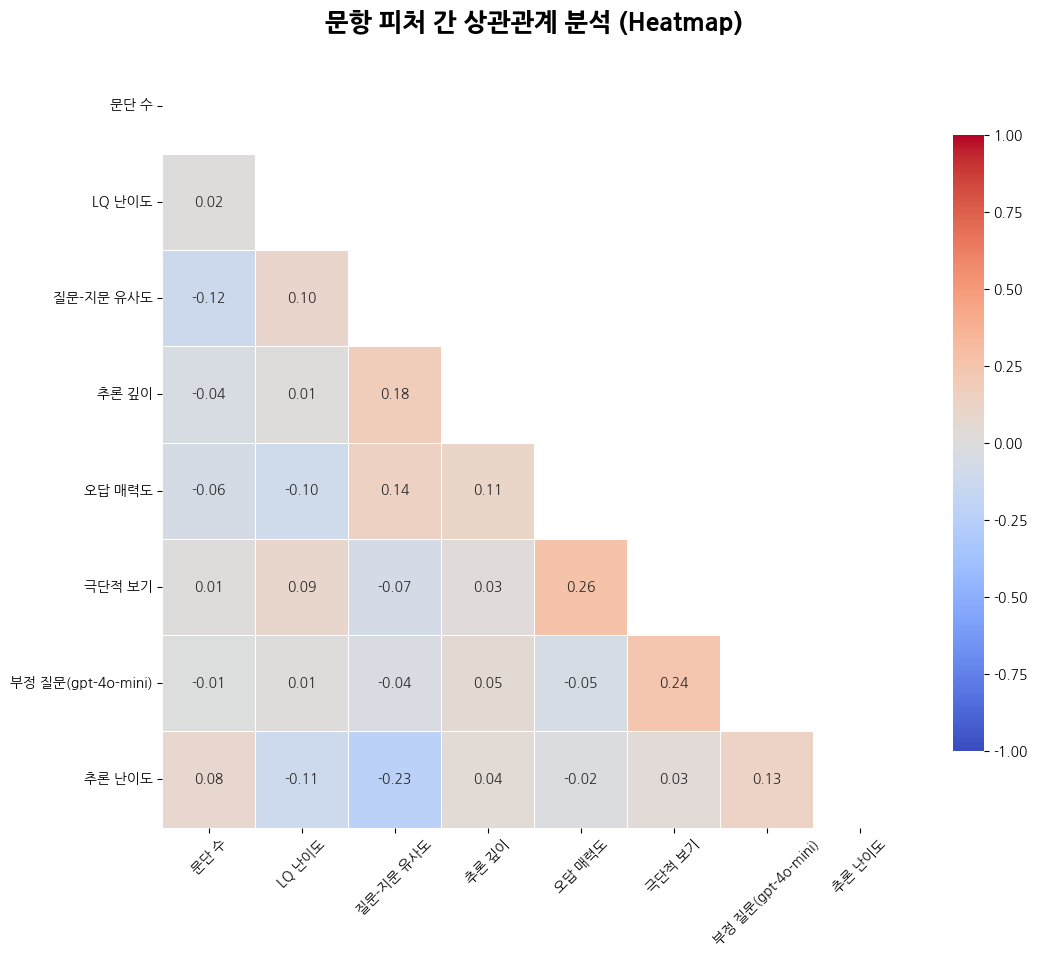

In [40]:
# 1. 상관계수를 계산할 피처 리스트
korean_labels = {
    # 'subject' : '카테고리',
    # 'from' : '문제출처',
    # 'avg_words_per_sent': '문장당 어절수',
    'num_paragraphs': '문단 수',
    # 'lq_ttr': '어휘 다양성',
    # 'lq_term_density': '용어 밀도',
    # 'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '추론 깊이',
    'final_distractor_attractiveness': '오답 매력도',
    # 'is_negative': '부정 질문',
    # 'q_type_ensemble' : '질문 유형',
    'extreme_correct_match' : "극단적 보기",
    # 'num_choices': '선지 개수', 
    'is_negative_llm' : '부정 질문(gpt-4o-mini)',
    # 'cognitive_type' : '문제 유형',
    'reasoning_step' : '추론 난이도',
}

# 2. 분석용 데이터프레임 생성 (존재하는 컬럼만 추출)
cols_to_use = [col for col in korean_labels.keys() if col in df.columns]
df_corr = df[cols_to_use].copy()

# 3. 컬럼명을 한글로 변경 (시각화 가독성 향상)
df_corr.columns = [korean_labels[col] for col in df_corr.columns]

# 4. 피어슨 상관계수 계산
corr_matrix = df_corr.corr()

# 5. 히트맵 시각화
plt.figure(figsize=(12, 10))
plt.rcParams['font.family'] = 'NanumGothic' # 한글 깨짐 방지

# mask: 대칭되는 윗부분을 가려 가독성 높임
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,           # 숫자 표시
            fmt=".2f",            # 소수점 둘째자리까지
            cmap='coolwarm',      # 양의 상관관계(빨강), 음의 상관관계(파랑)
            vmin=-1, vmax=1,      # 범위 고정
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('문항 피처 간 상관관계 분석 (Heatmap)', fontsize=18, pad=20, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

## 클러스터링을 위한 선정된 피처들만 추출해 분포 확인

제1주성분(PC1) 설명력: 28.56%
제2주성분(PC2) 설명력: 26.48%

### 주성분별 피처 기여도(Loadings) ###
                                      PC1       PC2
lq_score                        -0.488109  0.327615
final_distractor_attractiveness  0.733473 -0.029651
choice_p_similarity              0.446954  0.645385
is_negative_llm                 -0.154914  0.689397


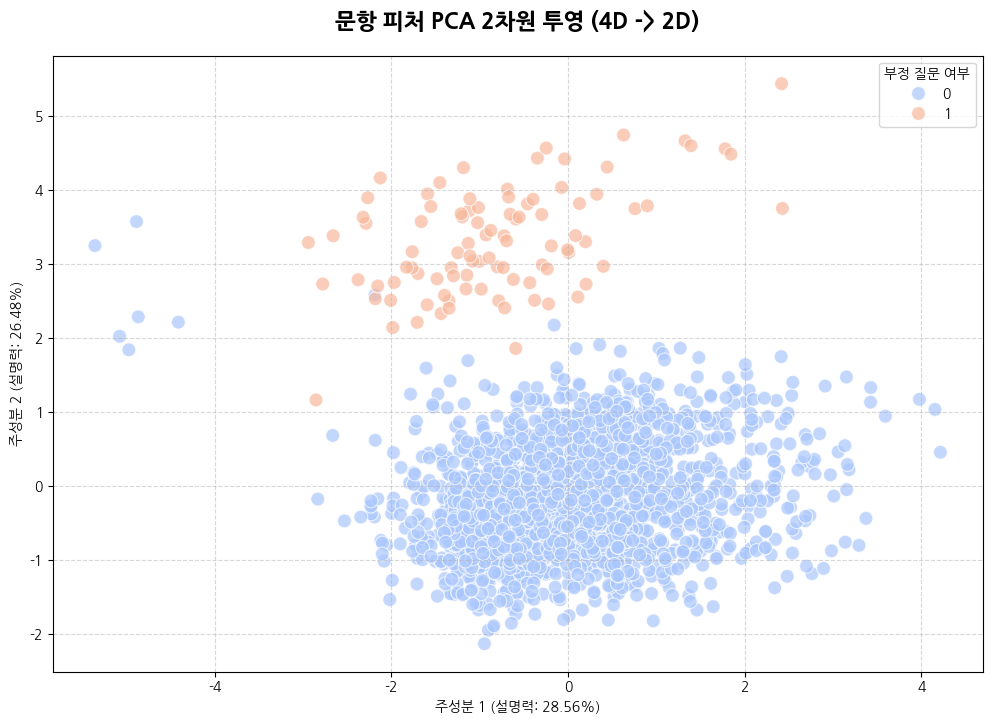

In [43]:
def plot_pca_2d(df):
    # 1. 분석에 사용할 4대 핵심 피처 추출
    features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative_llm']
    x_data = df[features].dropna()
    
    # 2. 데이터 표준화 (PCA는 스케일에 민감하므로 필수)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data)
    
    # 3. PCA 수행 (4차원 -> 2차원)
    pca = PCA(n_components=2, random_state=45)
    pca_result = pca.fit_transform(x_scaled)
    
    # 결과를 데이터프레임에 추가
    x_data['pca_1'] = pca_result[:, 0]
    x_data['pca_2'] = pca_result[:, 1]
    
    # 설명 가능한 분산 비율 출력 (정보가 얼마나 유지되었는지 확인)
    variance_ratio = pca.explained_variance_ratio_
    print(f"제1주성분(PC1) 설명력: {variance_ratio[0]:.2%}")
    print(f"제2주성분(PC2) 설명력: {variance_ratio[1]:.2%}")

    # 4. 시각화
    plt.figure(figsize=(12, 8))
    plt.rcParams['font.family'] = 'NanumGothic'
    
    # scatter plot (색상은 부정 질문 여부로 구분)
    scatter = sns.scatterplot(
        x='pca_1', y='pca_2', 
        hue='is_negative_llm', 
        data=x_data,
        palette='coolwarm',
        s=100, alpha=0.7, edgecolors='w'
    )
    
    plt.title('문항 피처 PCA 2차원 투영 (4D -> 2D)', fontsize=16, pad=20, fontweight='bold')
    plt.xlabel(f'주성분 1 (설명력: {variance_ratio[0]:.2%})')
    plt.ylabel(f'주성분 2 (설명력: {variance_ratio[1]:.2%})')
    plt.legend(title='부정 질문 여부', loc='upper right')
    
    # 주성분에 기여도가 높은 피처 확인 (해석을 돕기 위함)
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
    print("\n### 주성분별 피처 기여도(Loadings) ###")
    print(loadings)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# 실행
plot_pca_2d(df)

## 난이도 군집화 확인 (boundary 지정)

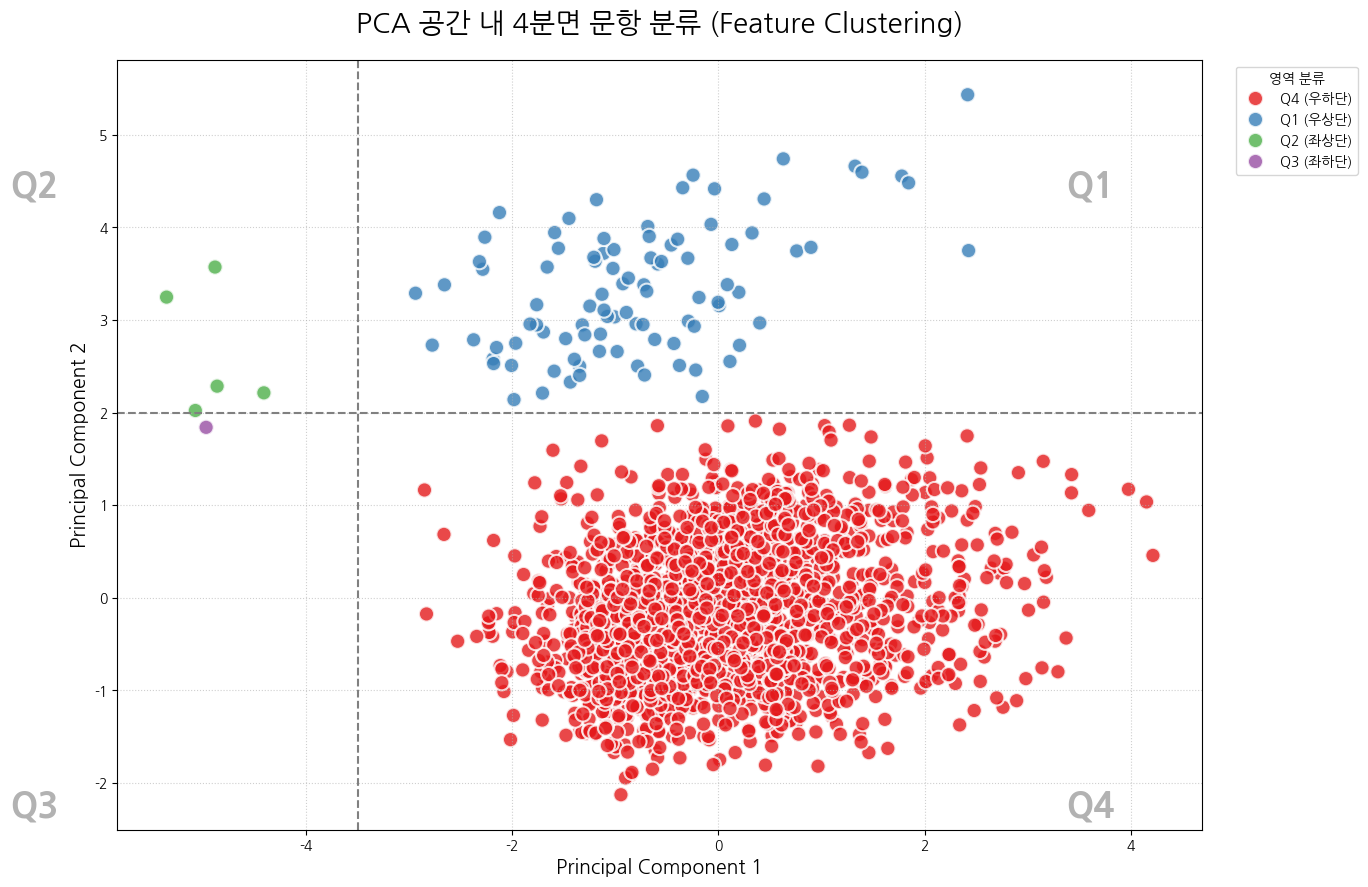


### [데이터 인사이트] 4분면 레이블별 핵심 피처 평균 분석 ###


,lq_score,final_distractor_attractiveness,choice_p_similarity,is_negative_llm
quadrant_label,,,,
Q1 (우상단),14.533,0.662,0.308,0.979
Q2 (좌상단),46.379,0.660,0.206,0.000
Q3 (좌하단),40.841,0.562,0.136,0.000
Q4 (우하단),13.895,0.693,0.260,0.001



[각 영역별 문항 수 분포]
quadrant_label
Q1 (우상단)      94
Q2 (좌상단)       5
Q3 (좌하단)       1
Q4 (우하단)    1931
Name: count, dtype: int64


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def update_df_with_pca_labels(df):
    # 1. 핵심 4대 피처 준비
    features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative_llm']
    
    # 분석 가능한 행의 인덱스와 데이터 추출
    valid_idx = df[features].dropna().index
    x_data_subset = df.loc[valid_idx, features].copy()
    
    # 2. 표준화 및 PCA 수행
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data_subset)
    
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(x_scaled)
    
    # 3. 임시 데이터프레임 생성 (시각화 및 라벨링용)
    temp_pca = pd.DataFrame(pca_result, columns=['pca_1', 'pca_2'], index=valid_idx)
    
    # 4. 4분면 라벨링 로직
    def assign_quadrant(row):
        p1, p2 = row['pca_1'], row['pca_2']
        if p1 > -3.5 and p2 > 2: return 'Q1 (우상단)'
        elif p1 <= -3.5 and p2 > 2: return 'Q2 (좌상단)'
        elif p1 <= -3.5 and p2 <= 2: return 'Q3 (좌하단)'
        else: return 'Q4 (우하단)'
        
    temp_pca['quadrant_label'] = temp_pca.apply(assign_quadrant, axis=1)

    # 5. 시각화 (Scatter Plot)
    plt.figure(figsize=(14, 10))
    # 한글 폰트 설정 (환경에 따라 'Malgun Gothic' 또는 'NanumGothic' 사용)
    plt.rcParams['font.family'] = 'NanumGothic' 
    plt.rcParams['axes.unicode_minus'] = False
    
    sns.scatterplot(
        x='pca_1', y='pca_2', 
        hue='quadrant_label', 
        palette='Set1',
        data=temp_pca,
        s=120, alpha=0.8, edgecolors='white', linewidth=1.5
    )
    
    # 기준선 추가
    plt.axvline(-3.5, color='gray', linestyle='--', linewidth=1.5)
    plt.axhline(2, color='gray', linestyle='--', linewidth=1.5)
    
    # 영역 텍스트 표기
    p1_limit = temp_pca['pca_1'].max() * 0.8
    p2_limit = temp_pca['pca_2'].max() * 0.8
    plt.text(p1_limit, p2_limit, 'Q1', fontsize=25, alpha=0.3, fontweight='bold')
    plt.text(-p1_limit-3.5, p2_limit, 'Q2', fontsize=25, alpha=0.3, fontweight='bold')
    plt.text(-p1_limit-3.5, -p2_limit+2, 'Q3', fontsize=25, alpha=0.3, fontweight='bold')
    plt.text(p1_limit, -p2_limit+2, 'Q4', fontsize=25, alpha=0.3, fontweight='bold')

    plt.title('PCA 공간 내 4분면 문항 분류 (Feature Clustering)', fontsize=20, pad=20)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.legend(title='영역 분류', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show() # 그래프 출력

    # 6. 최종 라벨 원본 df에 병합
    df['quadrant_label'] = temp_pca['quadrant_label']

    # 7. 레이블별 주요 피처 평균값 출력
    print("\n" + "="*90)
    print("### [데이터 인사이트] 4분면 레이블별 핵심 피처 평균 분석 ###")
    print("="*90)
    
    # 그룹바이 통계량 계산
    quadrant_stats = df.groupby('quadrant_label')[features].mean().sort_index()
    
    # 스타일링된 출력 (소수점 3자리)
    display(quadrant_stats.style.background_gradient(cmap='Blues').format("{:.3f}"))
    
    print("\n[각 영역별 문항 수 분포]")
    print(df['quadrant_label'].value_counts().sort_index())
    print("="*90)

# --- 실행 ---
update_df_with_pca_labels(df)

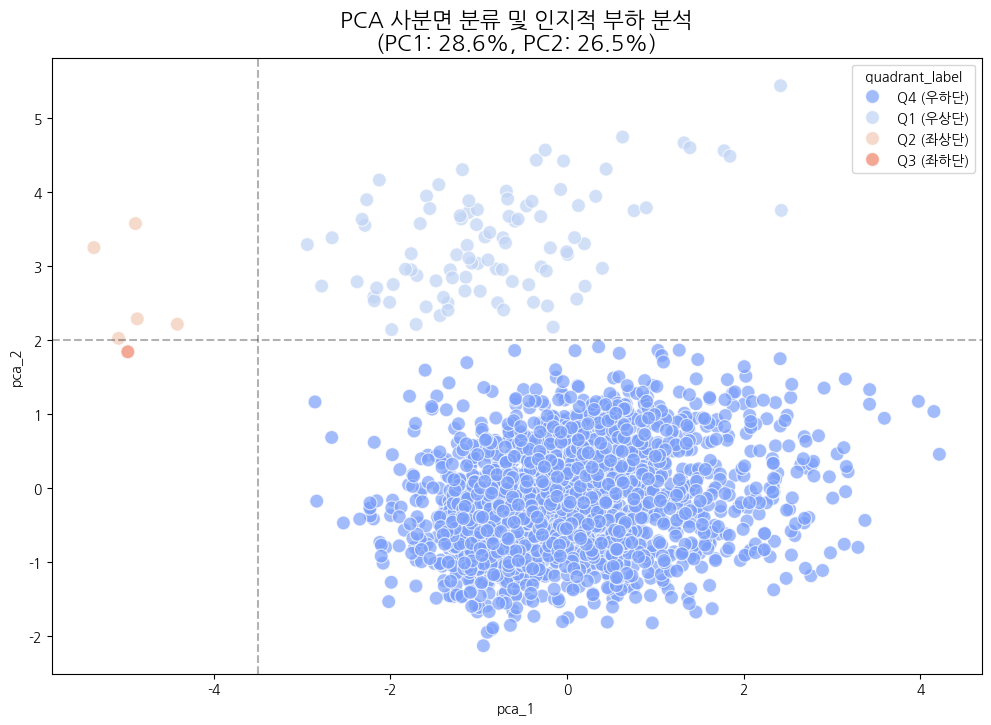


### [최종 검증] 4분면별 reasoning_step 및 핵심 피처 평균값 ###


,lq_score,final_distractor_attractiveness,choice_p_similarity,is_negative_llm,reasoning_step
quadrant_label,,,,,
Q1 (우상단),14.533,0.662,0.308,0.979,1.883
Q2 (좌상단),46.379,0.660,0.206,0.000,2.200
Q3 (좌하단),40.841,0.562,0.136,0.000,3.000
Q4 (우하단),13.895,0.693,0.260,0.001,1.410



[사분면별 문항 분포]
quadrant_label
Q1 (우상단)      94
Q2 (좌상단)       5
Q3 (좌하단)       1
Q4 (우하단)    1931
Name: count, dtype: int64


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def analyze_quadrant_with_reasoning(df):
    # 1. 분석에 사용할 핵심 피처 설정 (LLM 피처 포함)
    # PCA 계산에는 기존 4개 피처를 사용하고, 통계 확인 시 reasoning_step을 결합합니다.
    pca_features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative_llm']
    all_features = pca_features + ['reasoning_step']
    
    # 데이터 정제: 핵심 피처와 reasoning_step이 모두 있는 데이터만 추출
    valid_idx = df[all_features].dropna().index
    x_data_subset = df.loc[valid_idx, pca_features].copy()
    
    # 2. 표준화 및 PCA 수행 (설명력 확인 포함)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data_subset)
    
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(x_scaled)
    exp_var = pca.explained_variance_ratio_
    
    # 3. 임시 데이터프레임 생성 및 라벨링
    temp_pca = pd.DataFrame(pca_result, columns=['pca_1', 'pca_2'], index=valid_idx)
    
    def assign_quadrant(row):
        p1, p2 = row['pca_1'], row['pca_2']
        if p1 > -3.5 and p2 > 2: return 'Q1 (우상단)'
        elif p1 <= -3.5 and p2 > 2: return 'Q2 (좌상단)'
        elif p1 <= -3.5 and p2 <= 2: return 'Q3 (좌하단)'
        else: return 'Q4 (우하단)'
        
    temp_pca['quadrant_label'] = temp_pca.apply(assign_quadrant, axis=1)

    # 4. 시각화 (Scatter Plot)
    plt.figure(figsize=(12, 8))
    plt.rcParams['font.family'] = 'NanumGothic' # 환경에 맞는 한글 폰트 설정
    plt.rcParams['axes.unicode_minus'] = False
    
    sns.scatterplot(
        x='pca_1', y='pca_2', 
        hue='quadrant_label', 
        palette='coolwarm', # 직관적인 색상 변경
        data=temp_pca,
        s=100, alpha=0.7, edgecolors='w'
    )
    
    plt.axvline(-3.5, color='black', linestyle='--', alpha=0.3)
    plt.axhline(2, color='black', linestyle='--', alpha=0.3)
    plt.title(f'PCA 사분면 분류 및 인지적 부하 분석\n(PC1: {exp_var[0]:.1%}, PC2: {exp_var[1]:.1%})', fontsize=16)
    plt.show()

    # 5. 원본 데이터프레임 업데이트
    df.loc[valid_idx, 'quadrant_label'] = temp_pca['quadrant_label']

    # 6. [핵심] 사분면별 reasoning_step 포함 통계 요약 출력
    print("\n" + "="*95)
    print("### [최종 검증] 4분면별 reasoning_step 및 핵심 피처 평균값 ###")
    print("="*95)
    
    # 그룹화 및 평균 계산 (reasoning_step 포함)
    report = df.groupby('quadrant_label')[all_features].mean().sort_index()
    
    # 가독성을 높인 스타일링 출력
    display(report.style.background_gradient(cmap='YlGnBu', subset=['reasoning_step', 'lq_score'])\
                  .format("{:.3f}"))
    
    # 7. 결론 도출을 위한 문항 수 확인
    print("\n[사분면별 문항 분포]")
    print(df['quadrant_label'].value_counts().sort_index())
    print("="*95)

# --- 실행 ---
analyze_quadrant_with_reasoning(df)

In [49]:
df['quadrant_label'].unique()

array(['Q4 (우하단)', 'Q1 (우상단)', 'Q2 (좌상단)', 'Q3 (좌하단)'], dtype=object)

In [50]:
df.to_csv("../data/feature_engineering_train.csv", index=False)

In [ ]:
'''
극단적 - 오답 매력도
부정형 질문에서는 지금..가설이 맞은건데 틀렸다고
test 관련 데이터셋도 문제유형분류할거면 - 오픈소스로 아니면 API가 빠름
각 subject 별 샘플 10개 뽑아주기
'''

'\n극단적 - 오답 매력도\n부정형 질문에서는 지금..가설이 맞은건데 틀렸다고\ntest 관련 데이터셋도 문제유형분류할거면 - 오픈소스로 아니면 API가 빠름\n각 subject 별 샘플 10개 뽑아주기\n'